# 3. Automatic Feature Extraction in Convolution Neural Networks vs Manual Feature Extraction: Can Manual Feature Extraction outperform CNN's?

With CNNs being able to extract features from an input image (pixel dependencies etc.), are manual feature extraction methods obsolete? According to [this](https://datascience.stackexchange.com/questions/62409/is-manual-feature-extraction-outdated) stackexchange thread, it is not. We will test CNNs on image data and compare the results with using manual feature extraction (Grayscale values, mean channel value, edge detection) in combination with a more traditional ML algorithm: Decision trees.

We are especially interested in:
- The difference between E_in and E_out per method, as datasets with huge amount of features (such as images) might lead to model overfitting
- Differences between the errors of both methods
- To what extent is manual feature extraction still relevant in the case of image classification?
- What is the impact of different feature extraction techniques on model performance?

In [4]:
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPooling2D ,Input, InputLayer, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


from skimage import filters, feature
from skimage.io import imread, imshow

import tensorflow as tf
import pandas as pd
import numpy as np


## 3.1 Footwear Image data
Dataset is from [kaggle](https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images). It is an image classification problem with 3 classes: boot, sandal, shoe. It consists of 15k samples (5k samples of each class). The images are in RGB and of size 128x128. The orientation of all footwear in the dataset is the same, as well as the background (white). This should result in the models being able to learn without any image augmentation and still get high accuracy on the validation/test set. 

In [4]:
batch_size = 32
img_height = 128
img_width = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  './footwear_data',
  validation_split=0.2,
  subset="both",
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)
print(train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.
['Boot', 'Sandal', 'Shoe']


### 3.1.1 Convolutional Neural Network

We will use the same network architecture used for 1.6. The algorithm is explained in the beginning of section 1.5. Due to the use of convolutional layers, the network will learn what features are important by itself only using the fact that neighbouring pixels have some codependence. This means that image samples can be fed as-is through the network.

We use early stopping. This means that the algorithm stops training if no improvement to the validation accuracy is made over a set amount of epochs.

In [3]:
EPOCHS = 100

data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.2)
])

model = Sequential([
    Rescaling(1./255),
    data_augmentation,
    #InputLayer(input_shape = (128,128,3)),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    GlobalMaxPooling2D(),
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.2),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax') # use softmax because we have 3 classes instead of 2 (as in 1.7)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.build((batch_size, img_height, img_width, 3))
#model.save_weights("shoemodel.h5")
model.load_weights('shoemodel.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 128, 128, 3)         0         
                                                                 
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 128, 128, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 128, 128, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (32, 128, 128, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (32, 128, 128, 32)       128       
 hNormalization)                                      

In [34]:
early_stop = tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/100
375/375 [==============================] - 803s 2s/step - loss: 0.8659 - accuracy: 0.6409 - val_loss: 1.4428 - val_accuracy: 0.4340
Epoch 2/100
375/375 [==============================] - 784s 2s/step - loss: 0.5411 - accuracy: 0.7777 - val_loss: 3.2184 - val_accuracy: 0.4097
Epoch 3/100
375/375 [==============================] - 790s 2s/step - loss: 0.4217 - accuracy: 0.8347 - val_loss: 2.7795 - val_accuracy: 0.3960
Epoch 4/100
375/375 [==============================] - 779s 2s/step - loss: 0.3788 - accuracy: 0.8547 - val_loss: 1.6511 - val_accuracy: 0.3747
Epoch 5/100
375/375 [==============================] - 833s 2s/step - loss: 0.3449 - accuracy: 0.8688 - val_loss: 0.5662 - val_accuracy: 0.8037
Epoch 6/100
375/375 [==============================] - 706s 2s/step - loss: 0.2885 - accuracy: 0.8928 - val_loss: 4.1695 - val_accuracy: 0.3457
Epoch 7/100
375/375 [==============================] - 739s 2s/step - loss: 0.2704 - accuracy: 0.9008 - val_loss: 1.0304 - val_accuracy:

#### Degree of generalization
The difference between in-sample and out-sample error corresponds to the difference between loss and val_loss (epoch 8) => |1 - 0.2466 - (1 - 0.2452)| = 0.0014. This shows that our model is able to generalize very well.

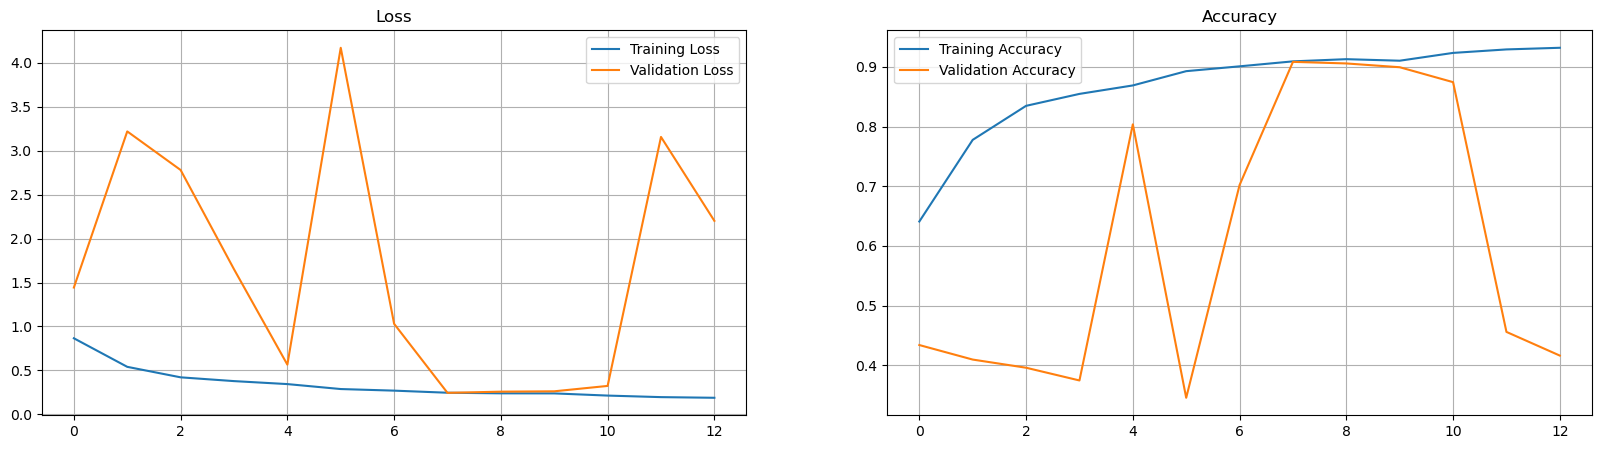

In [38]:
cnn_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(cnn_data.loss, label='Training Loss')
plt.plot(cnn_data.val_loss, label='Validation Loss')
plt.title("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_data.accuracy, label='Training Accuracy')
plt.plot(cnn_data.val_accuracy, label='Validation Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()

plt.show()

1/1 [==============================] - 0s 384ms/step
              precision    recall  f1-score   support

           0     0.9585    0.9528    0.9556      1017
           1     0.9479    0.8298    0.8849       987
           2     0.8329    0.9408    0.8835       996

    accuracy                         0.9083      3000
   macro avg     0.9131    0.9078    0.9080      3000
weighted avg     0.9133    0.9083    0.9084      3000



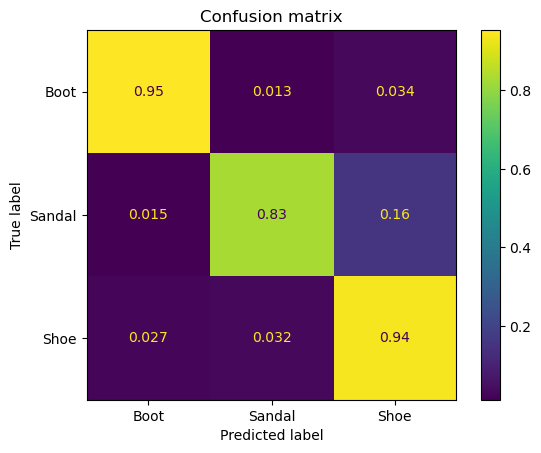

In [54]:
test_loss, test_accuracy = model.evaluate(val_ds)
accuracy = test_accuracy * 100

# slightly different functions as in 1.6 due to 3-class classification

def report_data_image(y_pred,y_true):
    print(classification_report(y_true,y_pred,digits=4))
    cm = confusion_matrix(y_true,y_pred, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Boot" , "Sandal", "Shoe"]).plot()
    disp.ax_.set_title('Confusion matrix')
    
    
def get_predictions_and_true_label(test_set, model):
    # iterate over the dataset
    y_pred = []
    for image_batch, label_batch in test_set:   # use dataset.unbatch() with repeat
        # compute predictions
        preds = model.predict(image_batch)

        # append predicted labels
        for prediction in preds:
            y_pred.append(prediction.argmax(axis=0))
        
    y_true = np.concatenate([y for x, y in test_set], axis=0)
    
    return y_true, y_pred

y_true, y_pred = get_predictions_and_true_label(val_ds, model)

report_data_image(y_pred, y_true)

1/1 [==============================] - 0s 288ms/step


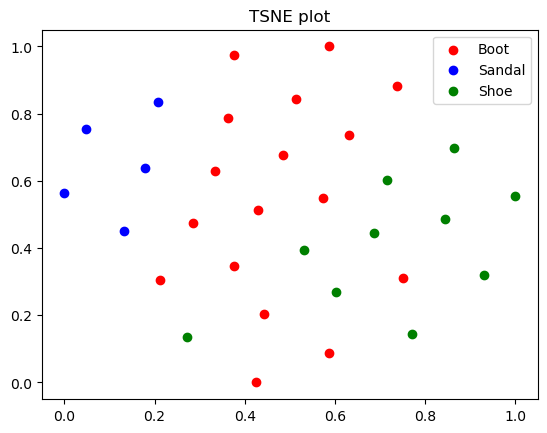

In [13]:
def TSNE_visualization_image(model, testX, title):
    

    model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    y_pred = []
    for p, _ in testX.take(1): # Takes 1 batch
        features = model2(p)         # Predict 1 batch
        preds = model.predict(p)

        for prediction in preds:
            y_pred.append(prediction.argmax(axis=0))
    
    labels = y_pred

    tsne = TSNE(n_components=2).fit_transform(features)

    def scale_to_01_range(x):
        value_range = (np.max(x) - np.min(x))
        starts_from_zero = x - np.min(x)
        return starts_from_zero / value_range
    
    def shrink_vector(vector, max_val):
        replacement = []
        for i in vector:
            if i > max_val:
                break
            else:
                replacement.append(i)
        return replacement

    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    colors = ['red', 'blue', 'green']
    classes = ["Boot" , "Sandal", "Shoe"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, c in enumerate(colors):
        indices = [i for i, l in enumerate(labels) if idx == l]
        indices = shrink_vector(indices, len(tx) - 1)
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

    ax.legend(loc='best')
    plt.title(title)
    plt.show()



TSNE_visualization_image(model, val_ds, 'TSNE plot')

From our experiments it is clear that CNN is able to classify the dataset very well with a validation accuracy of around 90%. The performance could still be improved (to around [97%](https://www.kaggle.com/code/venkatganesh98/shoevsbootvssandal-classification-cnn-acc-97#4.Model-Building)), but our results suffice for a good baseline to compare against.

### 3.1.2 Random forest classification

[motivation](https://ceur-ws.org/Vol-2320/short7.pdf)


Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.


c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


(3000, 16384)
(3000,)


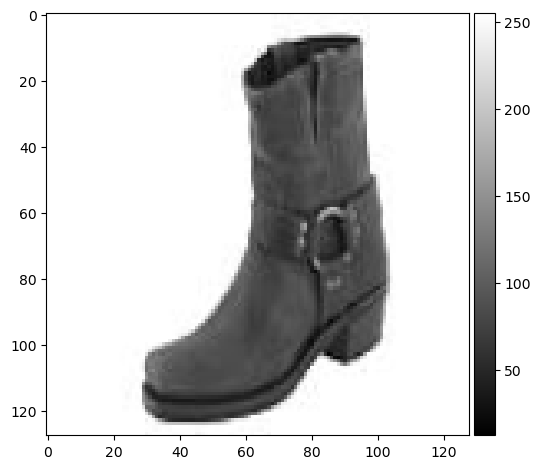

In [10]:
def report_data_image(y_pred,y_true):
    print(classification_report(y_true,y_pred,digits=4))
    cm = confusion_matrix(y_true,y_pred, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Boot" , "Sandal", "Shoe"]).plot()
    disp.ax_.set_title('Confusion matrix')

  
# redefine datasets for use with sklearn filters => grayscale
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  './footwear_data',
  validation_split=0.2,
  subset="both",
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)

# helper methods for converting from tf datasets to ndarrays supported by sklearn/skimage
def fetch_sample(ds):
  img, lbl = next(iter(ds))
  img = img.numpy().squeeze() # reduce dimensions to 2 because of grayscale
  return img, lbl.numpy()

def fetch_all(ds, filter=None):
  imgs = []
  lbls = []
  for img, lbl in ds:
    img = img.numpy().squeeze()
    if filter is not None:
      img = filter(img)
    imgs.append(img.reshape(128*128)) # flatten the image into a vector
    lbls.append(lbl.numpy())
  return np.array(imgs), np.array(lbls) # turn into a matrix

img, _ = fetch_sample(val_ds)
imgs, lbls = fetch_all(val_ds)
imshow(img, cmap='gray')
print(imgs.shape)
print(lbls.shape)

#### 3.1.2.1 Raw data
First, we test a random forest model on the raw image data, just as with CNN. We use the default parameters of RandomForestClassifier (100 trees, no max depth, min. 1 sample per leaf)

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.9646    0.9656    0.9651      1017
           1     0.9629    0.9210    0.9415       987
           2     0.9239    0.9629    0.9430       996

    accuracy                         0.9500      3000
   macro avg     0.9505    0.9498    0.9499      3000
weighted avg     0.9505    0.9500    0.9500      3000



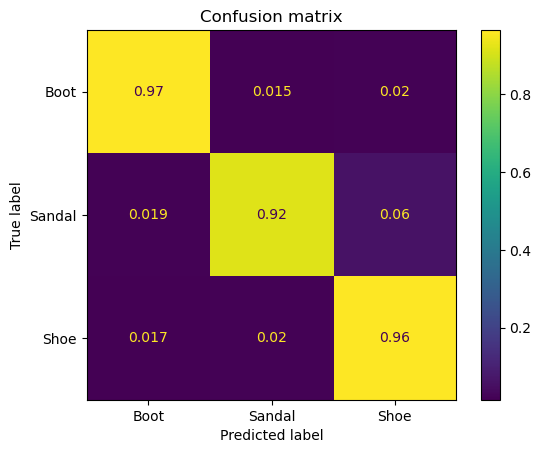

In [7]:
train_x, train_y = fetch_all(train_ds)
test_x, test_y = fetch_all(val_ds)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

We get a very high test score and a perfect training score, even without using any data augmentation (as opposed to used in the CNN) or hyperparameter tuning. This might be due to the simplicity of the dataset... We will investigate if we can improve upon this score even more by using edge detection filters.

#### 3.1.2.2 Sobel kernel
The sobel kernel is a 3x3 filter that is often used in edge detection. It calculates the approximate gradient of the image intensity function by using two 3x3 kernels that convolve the original image (one for x-axis, one for y-axis).

c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


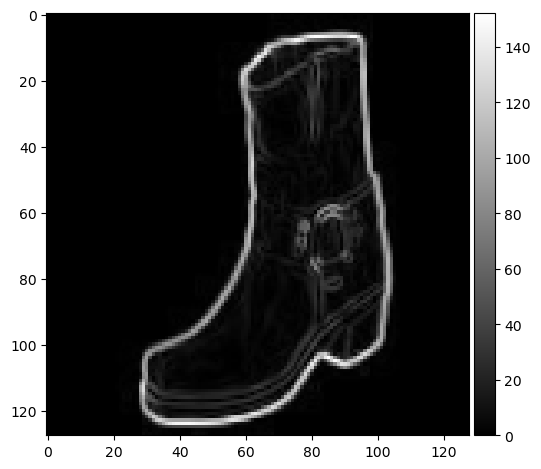

In [124]:
from skimage import filters

img, lbl = fetch_sample(val_ds)
sobel_img = filters.sobel(img)

imshow(sobel_img, cmap='gray')


Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.9390    0.9538    0.9463      1017
           1     0.9457    0.8652    0.9037       987
           2     0.8844    0.9448    0.9136       996

    accuracy                         0.9217      3000
   macro avg     0.9230    0.9213    0.9212      3000
weighted avg     0.9231    0.9217    0.9214      3000



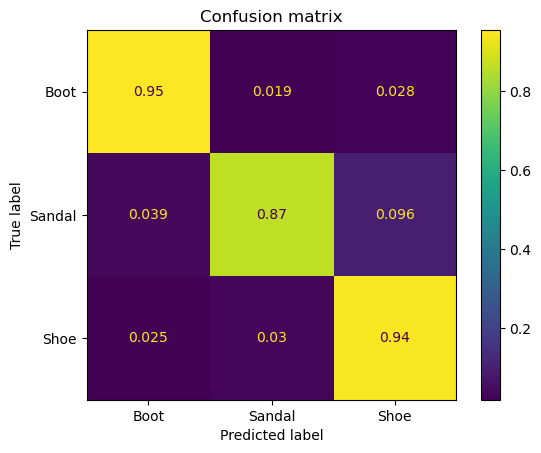

In [8]:
train_x, train_y = fetch_all(train_ds, filters.sobel)
test_x, test_y = fetch_all(val_ds, filters.sobel)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

Again we get a very accurate model, but contrary to our expectations, test accuracy has dropped slightly when compared to training on raw data.

#### 3.1.2.3 Laplace operator
Another method for edge detection. In contrast to Sobel the 2nd derivative of the image intensity is computed. Instead of using 2 kernels it uses 1 symmetrical kernel. We investigate whether this impacts learning performance.


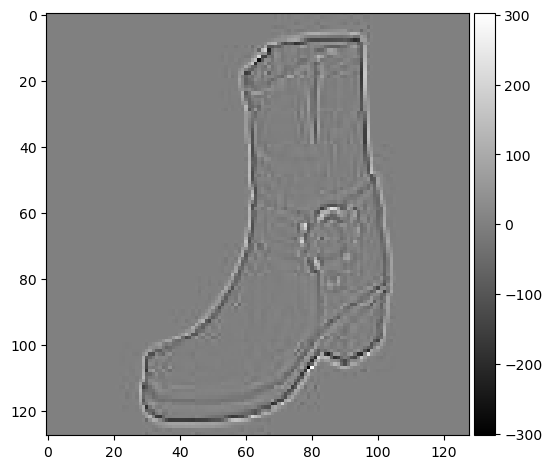

In [11]:
img, lbl = fetch_sample(val_ds)
img = filters.laplace(img)

imshow(img, cmap='gray')

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.8744    0.9312    0.9019      1017
           1     0.8842    0.7042    0.7840       987
           2     0.7816    0.8876    0.8312       996

    accuracy                         0.8420      3000
   macro avg     0.8468    0.8410    0.8390      3000
weighted avg     0.8468    0.8420    0.8396      3000



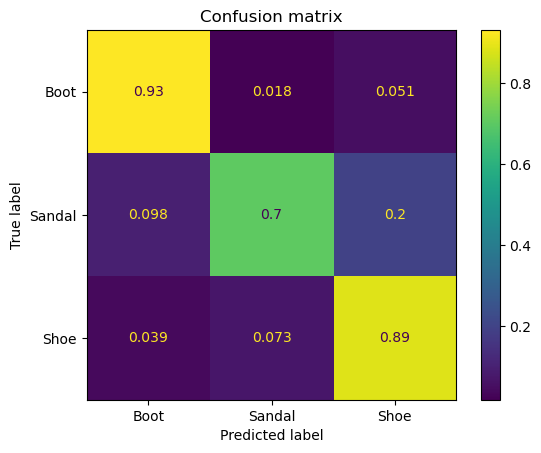

In [15]:
train_x, train_y = fetch_all(train_ds, filters.laplace)
test_x, test_y = fetch_all(val_ds, filters.laplace)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

Using the Laplace operator model performance has dropped even more compared to training on raw data and using the Sobel kernel. Especially the amount of misclassifications of sandals as shoes has increased.

For now we can conclude that on a simple dataset such as the footwear set we used, CNNs outperform simple manual feature extraction methods in combination with random forest classification. However, [more complicated techniques](https://ceur-ws.org/Vol-2320/short7.pdf) exist that involve changing the color space from rgb to the l\*a\*b\* scheme.

In order to explain the surprisingly high performance on raw image data, we can reason that it might be possible that the model learns to predict the footwear classes solely based on what pixels are lit up. This method could work due to the uniformity of samples in the dataset (same brightness, average position of footwear, orientation of footwear) In order to test this, we will resume with a more complex dataset for our subsequent experiments.

## 3.2 Muffin vs Chihuaha image dataset
Because we suspect that previous dataset gave the model opportunity to learn pixel locations 'by heart', we will use the same image data set as used in 1.6. We can compare the random forest classifier's results with the results of the CNN used in that section. It had an accuracy of 0.94 and an F1-score of 0.93.

Note that the classes are not entirely balanced with a ratio of 1.18 chihuahuas/muffin

### Loading the dataset

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


(1184, 4096)
(1184,)
['chihuahua', 'muffin']


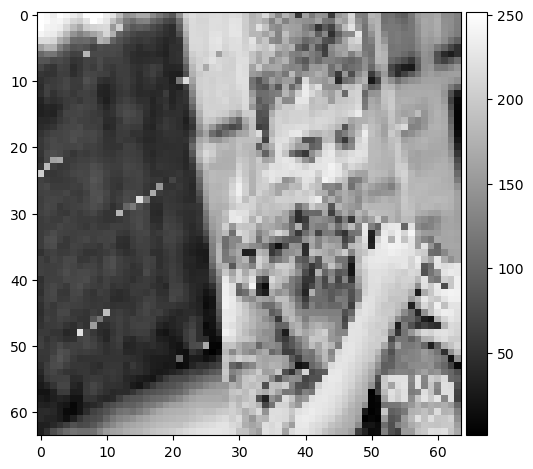

In [5]:
def report_data_image(y_pred,y_true):
    print(classification_report(y_true,y_pred,digits=4))
    cm = confusion_matrix(y_true,y_pred, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["chihuaha" , "muffin"]).plot()
    disp.ax_.set_title('Confusion matrix')

  
train_ds = tf.keras.utils.image_dataset_from_directory(
  './muffinchi/train',
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(64, 64),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)
test_ds = tf.keras.utils.image_dataset_from_directory(
  './muffinchi/test',
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(64, 64),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)

# helper methods for converting from tf datasets to ndarrays supported by sklearn/skimage
def fetch_sample(ds):
  img, lbl = next(iter(ds))
  img = img.numpy().squeeze() # reduce dimensions to 2 because of grayscale
  return img, lbl.numpy()

def fetch_all(ds, filter=None):
  imgs = []
  lbls = []
  for img, lbl in ds:
    img = img.numpy().squeeze()
    if filter is not None:
      img = filter(img)
    imgs.append(img.reshape(64*64)) # flatten the image into a vector
    lbls.append(lbl.numpy())
  return np.array(imgs), np.array(lbls) # turn into a matrix

img, _ = fetch_sample(test_ds)
imgs, lbls = fetch_all(test_ds)
imshow(img, cmap='gray')
print(imgs.shape)
print(lbls.shape)
print(train_ds.class_names)

### 3.2.1 Raw data
Train a decision tree on the raw data. We do not expect this to yield very accurate results due to the variety of images present in the data set.

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.8149    0.7359    0.7734       640
           1     0.7211    0.8033    0.7600       544

    accuracy                         0.7669      1184
   macro avg     0.7680    0.7696    0.7667      1184
weighted avg     0.7718    0.7669    0.7672      1184



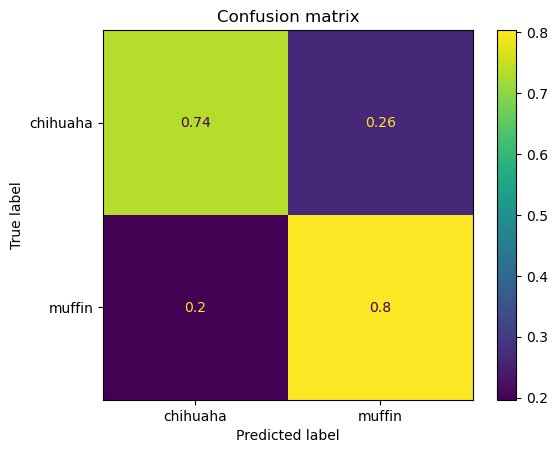

In [24]:
train_x, train_y = fetch_all(train_ds)
test_x, test_y = fetch_all(test_ds)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

The results are better than expected initially. Test accuracy is around 77%.

### 3.2.2 Sobel Kernel

Apply the Sobel kernel to observe its impact on learning.

c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


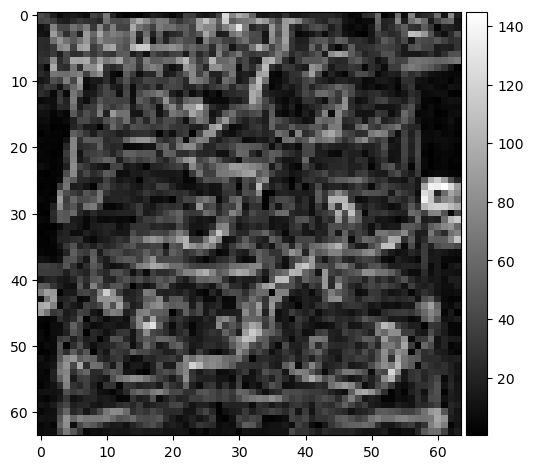

In [27]:
img, lbl = fetch_sample(test_ds)
sobel_img = filters.sobel(img)

imshow(sobel_img, cmap='gray')

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.8463    0.7656    0.8039       640
           1     0.7521    0.8364    0.7920       544

    accuracy                         0.7981      1184
   macro avg     0.7992    0.8010    0.7980      1184
weighted avg     0.8030    0.7981    0.7984      1184



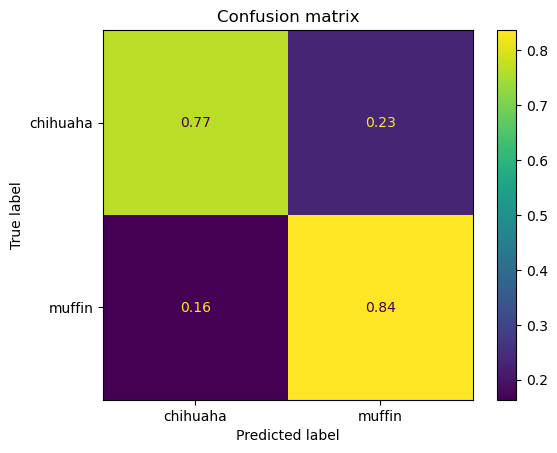

In [26]:
train_x, train_y = fetch_all(train_ds, filters.sobel)
test_x, test_y = fetch_all(test_ds, filters.sobel)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

Using Sobel kernel for edge detection, the model is able to achieve an accuracy of around 80%. Misclassifications of both muffins and dogs have been reduced.

### 3.2.3 Laplace operator

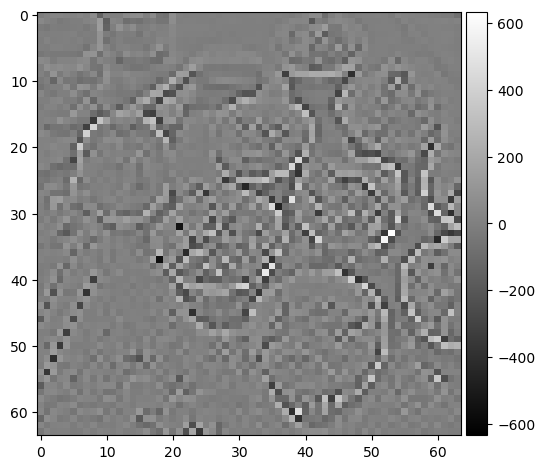

In [28]:
img, lbl = fetch_sample(test_ds)
img = filters.laplace(img)

imshow(img, cmap='gray')

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.8340    0.6984    0.7602       640
           1     0.7022    0.8364    0.7634       544

    accuracy                         0.7618      1184
   macro avg     0.7681    0.7674    0.7618      1184
weighted avg     0.7734    0.7618    0.7617      1184



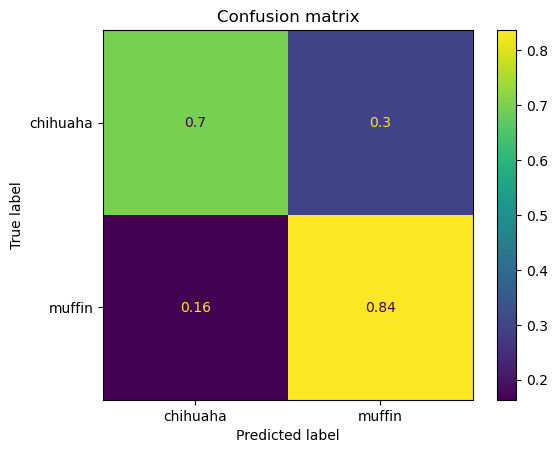

In [29]:
train_x, train_y = fetch_all(train_ds, filters.laplace)
test_x, test_y = fetch_all(test_ds, filters.laplace)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

Using the Laplace operator, accuracy drops to around 77%. Notably, the ratio of misclassified chihuahuas increased while the ratio of misclassified muffins remained the same as with the Sobel kernel.

### 3.2.4 Model tuning using Sobel kernel
Try to tune the Sobel kernel random forest model hyperparameters using gridsearchCV.

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .....................................max_depth=None; total time=  14.5s
[CV] END .....................................max_depth=None; total time=  15.2s
[CV] END .....................................max_depth=None; total time=  14.3s
[CV] END .....................................max_depth=None; total time=  14.5s
[CV] END .....................................max_depth=None; total time=  15.7s
[CV] END .......................................max_depth=10; total time=  12.7s
[CV] END .......................................max_depth=10; total time=  13.0s
[CV] END .......................................max_depth=10; total time=  13.1s
[CV] END .......................................max_depth=10; total time=  12.3s
[CV] END .......................................max_depth=10; total time=  12.5s
[CV] END .......................................max_depth=20; total time=  15.5s
[CV] END .......................................m

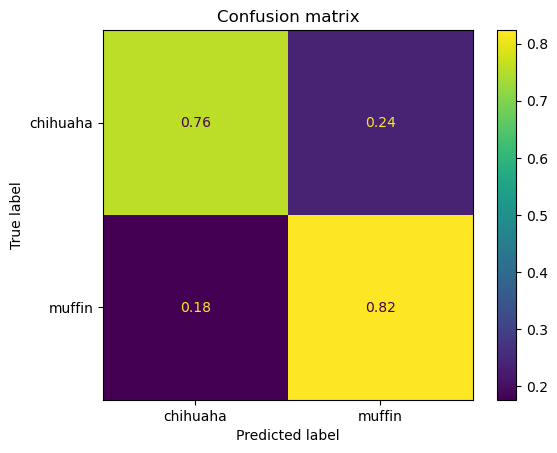

In [7]:
train_x, train_y = fetch_all(train_ds, filters.sobel)
test_x, test_y = fetch_all(test_ds, filters.sobel)

rf_model = RandomForestClassifier()

model = GridSearchCV(rf_model, {'max_depth': [None, 10, 20, 30, 50]}, verbose=2)
model.fit(train_x, train_y)

y_pred = model.predict(test_x)
y_pred_train = model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

In [8]:
print(model.best_params_)

{'max_depth': None}


The default max_depth hyperparameter of random forest is best set to None.

### 3.2.5 Histogram of Gradients (HOG)
HOG is a feature extraction pipeline that was originally used to recognize pedestrians. It works as follows:
- The pixel intensity gradient is calculated (Sobel filter)
- The histogram for the grid cells on the image is calculated
- Normalize across histogram blocks
- The features determined by the histogram can be used for classification 

In the [paper](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf), the optimal image size is 128*64 so we will use that size. Also 9 bins are used.

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
(1184, 8192)
(1184,)
['chihuahua', 'muffin']


c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


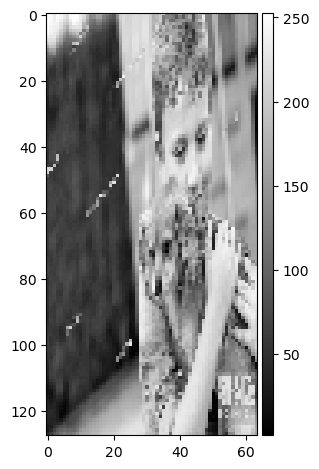

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './muffinchi/train',
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(128, 64),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)
test_ds = tf.keras.utils.image_dataset_from_directory(
  './muffinchi/test',
  labels='inferred',
  label_mode='int',
  seed=123,
  image_size=(128, 64),
  color_mode='grayscale',
  shuffle=True,
  batch_size=None)

# helper methods for converting from tf datasets to ndarrays supported by sklearn/skimage
def fetch_sample(ds):
  img, lbl = next(iter(ds))
  img = img.numpy().squeeze() # reduce dimensions to 2 because of grayscale
  return img, lbl.numpy()

# returns all HOG features from a dataset
def fetch_all_hog(ds):
  imgs = []
  lbls = []
  for img, lbl in ds:
    hog_feat = feature.hog(img)
    imgs.append(hog_feat)
    lbls.append(lbl.numpy())
  return np.array(imgs), np.array(lbls) # turn into a matrix

img, _ = fetch_sample(test_ds)
imgs, lbls = fetch_all(test_ds)
imshow(img, cmap='gray')
print(imgs.shape)
print(lbls.shape)
print(train_ds.class_names)

c:\Users\liamm\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


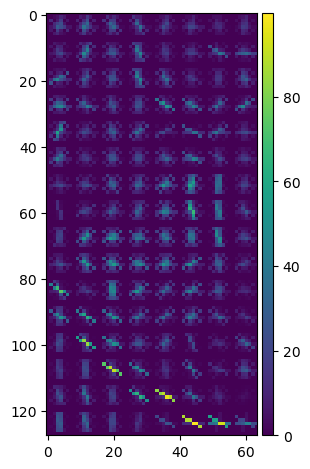

In [10]:
img, _ = fetch_sample(test_ds)
HOG, viz = feature.hog(img, visualize=True)
imshow(viz)

Training accuracy: 1.0
              precision    recall  f1-score   support

           0     0.7958    0.8281    0.8116       640
           1     0.7876    0.7500    0.7684       544

    accuracy                         0.7922      1184
   macro avg     0.7917    0.7891    0.7900      1184
weighted avg     0.7921    0.7922    0.7918      1184



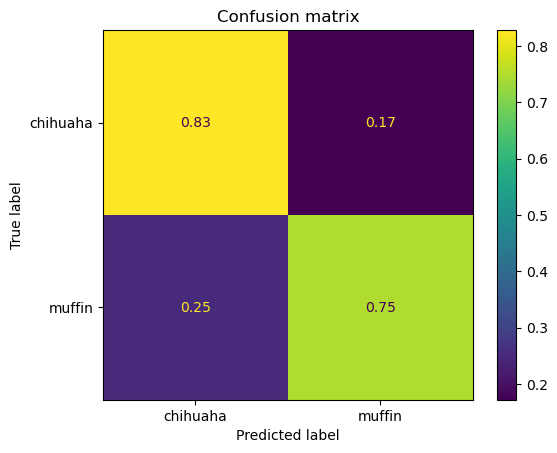

In [13]:
train_x, train_y = fetch_all_hog(train_ds)
test_x, test_y = fetch_all_hog(test_ds)

rf_model = RandomForestClassifier()
rf_model.fit(train_x, train_y)

y_pred = rf_model.predict(test_x)
y_pred_train = rf_model.predict(train_x)
print('Training accuracy:', accuracy_score(train_y, y_pred_train))
report_data_image(y_pred, test_y)

We have a slightly lower accuracy than when using Sobel filtering. The ratios of misclassified muffins and chihuahuas are respectively higher and lower than when using Sobel. This might be due to the way that features are represented in HOG.

## 3.3 Results & Conclusion
### 3.3.1 Results
| Accuracy | CNN | Random Forest (RF) | RF + Sobel | RF + Laplace | RF + HOG |
| --- | --- | --- | --- | --- | ---|
| Footwear catalog | 0.90 | 0.95 | 0.92 | 0.85 | \ |
| Muffins & Dogs | 0.94 | 0.77 | 0.80 | 0.77 | 0.79 |  
### 3.3.2 Conclusion
From our experiments on the footwear dataset we can clearly see that simple ML methods can approximate CNN performance in a scenario of image classification, where images are very uniform in terms of the position, orientation and shape of the object to be classified. The accuracy of our CNN are even worse than those of the random forest classifier on the raw data (however better performance should be achievable for CNN). This means that in the case of image recognizition for a catalog of items in a shop, where most items are similarly photgraphed, training of a CNN is not always necessary. Training a CNN can be time-consuming process (ours took around 120 mins.), while training our random forest can be done in under 10 mins. Training times also increase with the amount of classes and samples so for complex problems this difference will only grow. Also, the sample efficiency of the random forest is better compared to CNN: looking at the accuracy/epoch in the graph in 3.1.1, CNN required 8 epochs (= passes through whole training set) to get to its accuracy of 90%, while random forest requires only 1.

During our experiments on the muffins vs chihuahuas dataset, we noticed that the CNN consistently outperformed our feature extraction techniques + random forest. We can accredit this to the more complex imagery in the dataset. Even though the accuracy is worse at around 10% less, it is still not bad and improvement could be made using more complicated feature extraction techniques such as [SIFT](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.SIFT), [FCTH](https://ieeexplore.ieee.org/document/4556917) or [ORB](https://iopscience.iop.org/article/10.1088/1742-6596/1237/3/032020/pdf).